## ベルヌーイ分布の学習と予測

Stan 版です。

In [3]:
# stanのバージョンが v3.3 になり import pystan ではなくではなく import stan とライブラリ名がが
# 変わると当時に、build 時に以下のエラーがでるようになった。
# 対策としてnest_asyncio というライブラリを使う必要があるため、最初の一回のみライブラリをインストールしておくしておく
# 一回 install すれば、あとはこのコマンドは不要なので、先頭にに#をつけてコメントにしておいてください。
## RuntimeError: asyncio.run() cannot be called from a running event loop

!pip install pystan
!pip install nest_asyncio

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import beta # ベータ分布

# pystan と、パラメータの事後分布の推定結果を可視化するためのライブラリとして arviz を利用する。
import stan
import arviz
import nest_asyncio # stanのバージョンアップ対策
nest_asyncio.apply() # stanのバージョンアップ対策


[0.75 0.25]


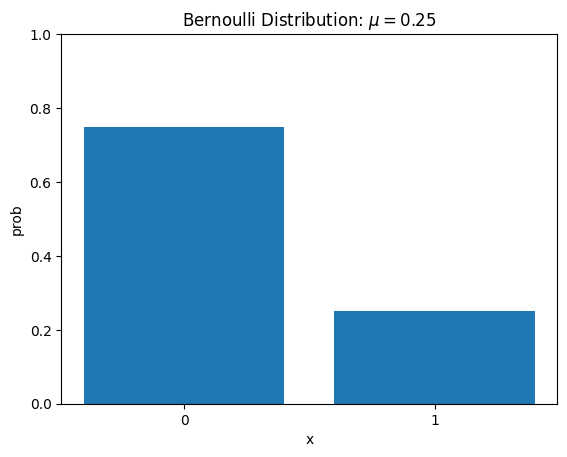

In [5]:
## 真のモデルの設定

# 真のパラメータを指定
mu_truth = 0.25

# x軸の値を設定
x_point = np.array([0, 1])

# 尤度(ベルヌーイ分布)を計算
true_model = np.array([1 - mu_truth, mu_truth]) # 確率
print(true_model)

# 尤度を作図
plt.bar(x=x_point, height=true_model) # 尤度
plt.xlabel('x')
plt.ylabel('prob')
plt.xticks(ticks=x_point, labels=x_point) # x軸目盛
plt.title('Bernoulli Distribution: $\mu=' + str(mu_truth) + '$')
plt.ylim(0.0, 1.0)
plt.show()



0.24


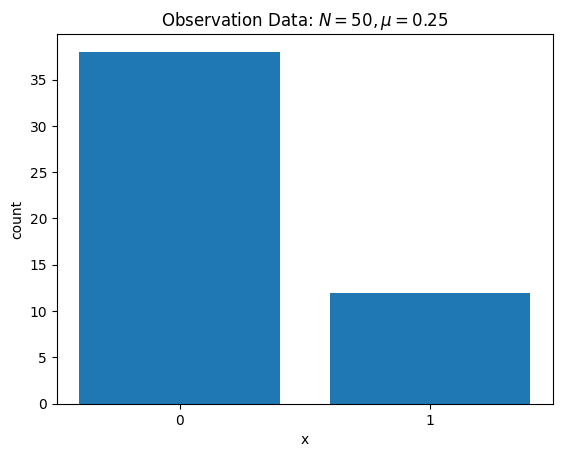

array([1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [6]:
## 観測データの生成

# データ数を指定
N = 50

# (観測)データを生成
x_n = np.random.binomial(n=1, p=mu_truth, size=N)
print(np.sum(x_n) / N)

# 観測データのヒストグラムを作図
plt.bar(x=x_point, height=[N - np.sum(x_n), np.sum(x_n)]) # 観測データ
plt.xlabel('x')
plt.ylabel('count')
plt.xticks(ticks=x_point, labels=x_point) # x軸目盛
plt.title('Observation Data: $N=' + str(N) + ', \mu=' + str(mu_truth) + '$')
plt.show()

x_n

In [7]:
# stan に入力できる形式である辞書型にする
data = pd.DataFrame({'y': x_n})

# Stan で扱えるよう辞書型の指定されたスタイルに変更する
stan_data = data.to_dict('list') # 辞書型に変換
stan_data.update({'N':len(data)}) # N の項目を追加
print (stan_data)

{'y': [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'N': 50}


In [8]:
stan_data

{'y': [1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'N': 50}

In [12]:
stan_code = """
data {
    int N;
    array[N] int<lower=0, upper=1> y;
}
parameters {
    real<lower=0,upper=1> p;
}
model {
    p ~ beta(1, 1);
    for (i in 1:N) {
        y[i] ~ bernoulli(p);
    }
}
"""


In [13]:
model = stan.build(stan_code, data=stan_data, random_seed=1) # テキスト情報からモデルに加えて、対象データと乱数の種を指定し、コンパイル, 数分かかるかも


Building...



Building: 39.9s, done.

In [14]:
# MCMCの実行
fit = model.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples = 2000, # 繰り返し回数
    num_thin = 1, #間引き数
)

Sampling:   0%
Sampling:  22% (2700/12000)
Sampling:  48% (5700/12000)
Sampling:  72% (8700/12000)
Sampling:  92% (11100/12000)
Sampling:  95% (11400/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!


   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
p  0.25  0.059   0.144    0.364      0.001    0.001    2705.0    3749.0    1.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.25,0.059,0.144,0.364,0.001,0.001,2705.0,3749.0,1.0


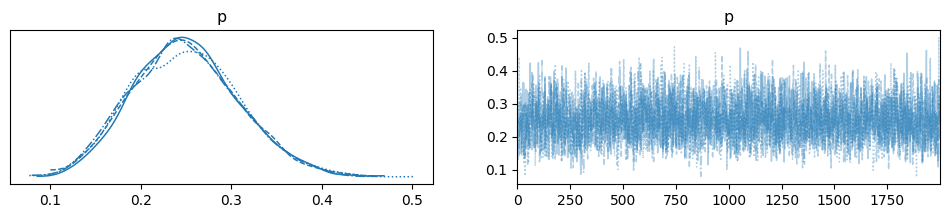

In [15]:
# MCMCの経過を簡易表示, muとsigmaのiter変化が見られる
arviz.plot_trace(fit)

#  Gelman-Rubin 統計量などの簡易表示
summary = arviz.summary(fit)
print (summary)

summary


In [16]:
result = fit.to_frame()

# 統計量の概要を確認
print(result.describe().T)

# 先頭を表示
result.head()

                count       mean       std        min        25%        50%  \
parameters                                                                    
lp__           8000.0 -29.744390  0.707884 -36.531504 -29.912927 -29.470081   
accept_stat__  8000.0   0.913392  0.127160   0.030125   0.877026   0.969063   
stepsize__     8000.0   1.058841  0.051447   0.979488   1.042883   1.066230   
treedepth__    8000.0   1.365000  0.481460   1.000000   1.000000   1.000000   
n_leapfrog__   8000.0   2.368750  1.017425   1.000000   1.000000   3.000000   
divergent__    8000.0   0.000000  0.000000   0.000000   0.000000   0.000000   
energy__       8000.0  30.240074  0.980373  29.241563  29.528503  29.950073   
p              8000.0   0.249972  0.059132   0.076409   0.207582   0.247431   

                     75%        max  
parameters                           
lp__          -29.289822 -29.241428  
accept_stat__   1.000000   1.000000  
stepsize__      1.082188   1.123417  
treedepth__     2.0

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,p
draws,,,,,,,,
0,-30.285665,1.000000,1.064015,2.0,3.0,0.0,30.628770,0.170567
1,-29.725860,0.873659,1.068445,1.0,3.0,0.0,29.942178,0.194215
2,-29.348081,0.984299,1.123417,2.0,3.0,0.0,29.373787,0.278392
3,-30.163326,0.771905,0.979488,1.0,3.0,0.0,30.655183,0.174918
4,-29.459686,0.997167,1.064015,1.0,3.0,0.0,30.083187,0.211793


0.24997183595113517


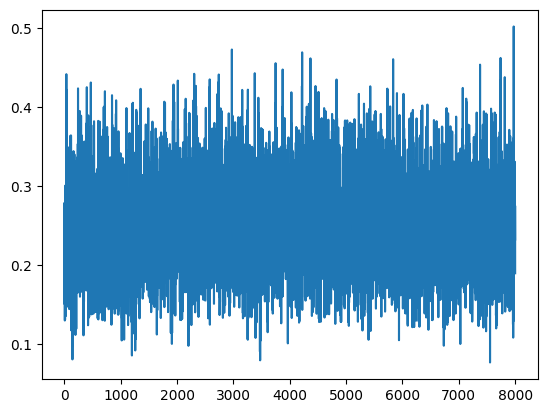

In [17]:
plt.plot(result["p"])
print (result['p'].mean())
mu_hat_star = result['p'].mean()

(array([  41.,  437., 1377., 2095., 2064., 1265.,  528.,  152.,   35.,
           6.]),
 array([0.07640869, 0.11894245, 0.16147621, 0.20400996, 0.24654372,
        0.28907748, 0.33161124, 0.37414499, 0.41667875, 0.45921251,
        0.50174627]),
 <BarContainer object of 10 artists>)

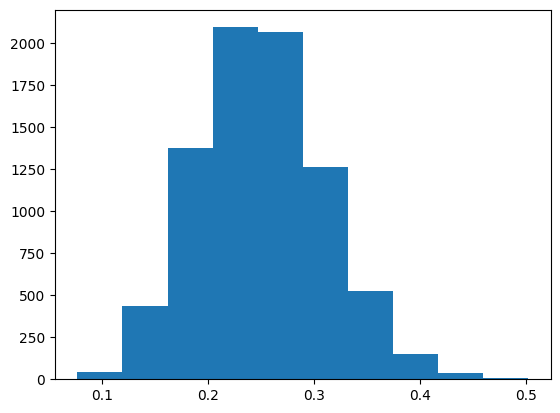

In [18]:
plt.hist(result['p'])

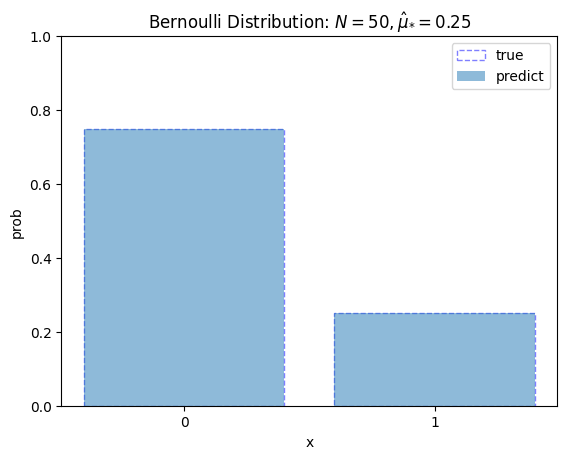

In [19]:
# 予測分布(ベルヌーイ分布)を計算
predict = np.array([1 - mu_hat_star, mu_hat_star]) # 確率

# 予測分布を作図
plt.bar(x=x_point, height=true_model, label='true', alpha=0.5,
        color='white', edgecolor='blue', linestyle='dashed') # 真のモデル
plt.bar(x=x_point, height=predict, label='predict', alpha=0.5) # 予測分布
plt.xlabel('x')
plt.ylabel('prob')
plt.xticks(ticks=x_point, labels=x_point) # x軸目盛
plt.title('Bernoulli Distribution: $N=' + str(N) + ', \hat{\mu}_{*}=' + str(np.round(mu_hat_star, 2)) + '$')
plt.ylim(0.0, 1.0)
plt.legend()
plt.show()